### Imports

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means


random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Using TensorFlow backend.


Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [55]:
batch_size=64

In [2]:

tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [3]:
!nvidia-smi

Wed Dec 20 21:57:54 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0    37W / 300W |    430MiB / 16152MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Load Data

In [4]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()
train_df = data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


### Missing values

In [6]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,39.268707
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,39.268707
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,39.268707
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,39.268707
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,39.268707


### Transform for NN

In [7]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

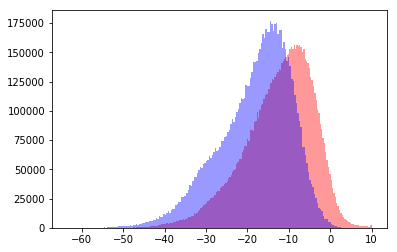

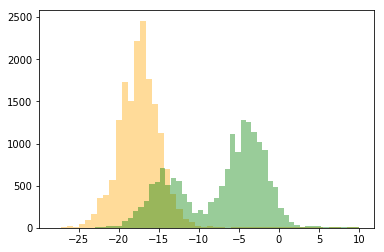

In [8]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

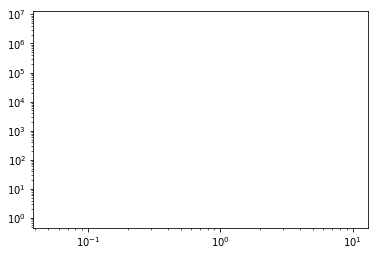

In [9]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

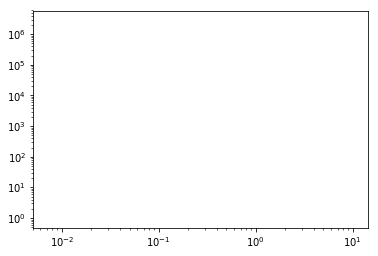

In [10]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [11]:
print(X.max())
print(X.min())
print(X.std())

10.0
-63.464207
9.98626650294


In [12]:
# pre-processing: divide by max and substract mean

#scale = np.max(X_train)
#X_train /= scale

#mean = np.mean(X_train)
#X_train -= mean

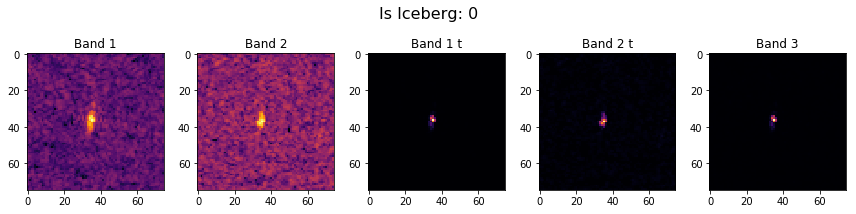

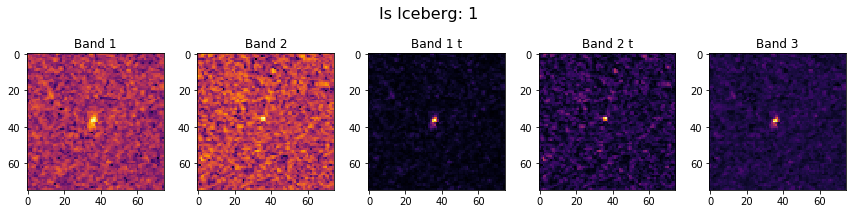

In [13]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [14]:
# = to_categorical(train_df.loc[:,'is_iceberg'], num_classes=2)
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index
#y_angle['band_3'] = pd.Series(band_3.tolist()).apply(np.array)

In [15]:
y_angle.head()

,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


### Split into train test and validation sets

In [16]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.3, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1122, 75, 75, 4)
(482, 75, 75, 4)


### Data augmentation

In [17]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3],temp_band_3),axis=3)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        #original_index = temp_data[1][:,2].astype(np.int)
        #denoised_temp = apply_over_axis(denoising, temp_stacked) #denoise all channels
        nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        #filtered_temp = apply_over_axis(img_filtering, temp_data[0], mask=denoised_temp) #filter regional maxima on nn_denoised bands
        #dilated_temp = apply_over_axis(img_dilated, denoised_temp) #use dilated images
        return [temp_stacked1, temp_stacked2, 
                nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

#flow = datagen.flow(X_train, y_train)
#temp = flow.next()

(1122, 75, 75, 4)


In [18]:
temp = next(datagen_angle.flow(X_train_sample,y_train_sample, batch_size=24).generator)
temp[1][:,1].shape

(24,)

### Denoising

In [19]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [20]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [21]:
X_denoised = apply_over_axis(denoising, X)

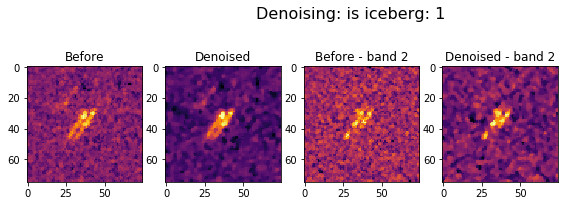

In [22]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("Denoised")
ax2.imshow(X_denoised[original_index][:,:,0], cmap=cmap)
ax1 = fig.add_subplot(253)
ax1.set_title("Before - band 2")
ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax2 = fig.add_subplot(254)
ax2.set_title("Denoised - band 2")
ax2.imshow(X_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

### NN denoising

In [23]:
#custom generator for denoising
from collections import Generator
class Datagen_denoising(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3]),axis=3)
        return temp_stacked, temp_stacked
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
        
datagen_denoising = Datagen_denoising(imagegen=datagen)
datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [24]:
m_input = Input(shape=(75,75,4), name='m_input')

#conv layers for main_input
x1 = BatchNormalization()(m_input)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')

model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])

In [27]:
model_denoise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_input (InputLayer)         (None, 75, 75, 4)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 4)         16        
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 77, 77, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 8)         296       
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 8)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 77, 77, 8)         0         
__________

In [57]:
#model training
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=batch_size),
                    steps_per_epoch=len(X)/batch_size,
                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=batch_size, shuffle=False), 
                    validation_steps=len(X)/batch_size,
                    #validation_data=[X_val,y_val],
                    epochs=10)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/10
26/25 [===============================] - 2s 92ms/step - loss: 3.8492 - mean_absolute_error: 1.0904 - val_loss: 9.7802 - val_mean_absolute_error: 1.8333
Epoch 2/10
26/25 [===============================] - 2s 86ms/step - loss: 3.8444 - mean_absolute_error: 1.0839 - val_loss: 2.9544 - val_mean_absolute_error: 1.0771
Epoch 3/10
26/25 [===============================] - 2s 85ms/step - loss: 3.2049 - mean_absolute_error: 1.0167 - val_loss: 7.3514 - val_mean_absolute_error: 1.5981
Epoch 4/10
26/25 [===============================] - 2s 88ms/step - loss: 4.0816 - mean_absolute_error: 1.1218 - val_loss: 6.6884 - val_mean_absolute_error: 1.8107
Epoch 5/10
26/25 [===============================] - 2s 86ms/step - loss: 4.5260 - mean_absolute_error: 1.1396 - val_loss: 2.7388 - val_mean_absolute_error: 0.8938
Epoch 6/10
26/25 [===============================] - 2s 87ms/step - loss: 6.0459 - mean_absolute_error: 1.4052 - val_loss: 6.1670 - val_mean_absolute_error: 1.5220
Epoch 7/10
26/25

In [58]:
X_nn_denoised = model_denoise.predict(X, verbose=1)

1604/1604 [==============================] - 0s 184us/step


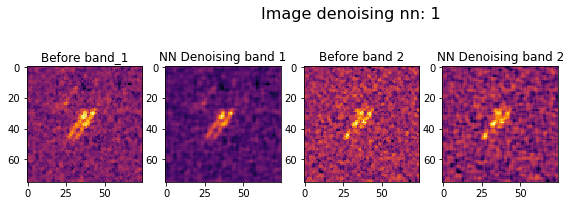

In [59]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before band_1")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("NN Denoising band 1")
ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
ax3 = fig.add_subplot(253)
ax3.set_title("Before band 2")
ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax4 = fig.add_subplot(254)
ax4.set_title("NN Denoising band 2")
ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

### Filtering regional maxima

In [31]:
def img_filtering(img,mask,h=0.75):
    img_list = []
    for i in range(img.shape[2]):
        image = img[:,:,i]
        mask1 = mask[:,:,i]
        h = (mask1.max() - mask1.min()) * h
        seed = mask1 - h
        dilated = reconstruction(seed, mask1, method='dilation')
        hdome = image * dilated
        img_list.append(hdome)
    return np.stack(img_list,axis=2)

def img_dilated(mask,h=0.2):
    img_list = []
    for i in range(mask.shape[2]):
        mask1 = mask[:,:,i]
        h = (mask1.max() - mask1.min()) * h
        seed = mask1 - h
        dilated = reconstruction(seed, mask1, method='dilation')
        img_list.append(dilated)
    return np.stack(img_list,axis=2)    

In [32]:
X_filtered = apply_over_axis(img_filtering, X, mask=X_denoised)
X_dilated = apply_over_axis(img_dilated, X_denoised )

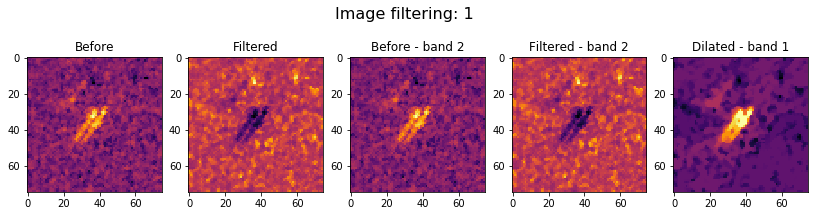

In [33]:
base_images = X_train_sample
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(14,6))
fig.suptitle("Image filtering: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before")
ax1.imshow(base_images[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("Filtered")
ax2.imshow(X_filtered[original_index][:,:,0], cmap=cmap)
ax1 = fig.add_subplot(253)
ax1.set_title("Before - band 2")
ax1.imshow(base_images[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(254)
ax2.set_title("Filtered - band 2")
ax2.imshow(X_filtered[original_index][:,:,0], cmap=cmap)
ax4 = fig.add_subplot(255)
ax4.set_title("Dilated - band 1")
ax4.imshow(X_dilated[original_index][:,:,0], cmap=cmap)
plt.show()

### Keras model

In [73]:
model_code="CNN_2017_12_19_v15"
model_comment="VOLTA 2 CNN inputs 3,3 conv filters - inception module less inputs"

In [61]:
%%writefile current_model.py

def InceptionBlock(x, n_kernels=32, prefix=''):
    path1 = Conv2D(n_kernels, (1,1), padding='same', activation='relu', name=prefix + '11_Conv_1_1')(x)
    
    path2 = Conv2D(n_kernels, (1,1), padding='same', activation='relu', name=prefix + '21_Conv_1_1')(x)
    path2 = Conv2D(n_kernels, (3,3), padding='same', activation='relu', name=prefix + '22_Conv_3_3')(path2)
    
    path3 = Conv2D(n_kernels, (1,1), padding='same', activation='relu', name=prefix + '31_Conv_1_1')(x)
    path3 = Conv2D(n_kernels, (5,5), padding='same', activation='relu', name=prefix + '32_Conv_5_5')(path3)
    
    path4 = MaxPooling2D((3,3), strides=(1,1), padding='same', name=prefix + '41_MaxPool_3_3')(x)
    path4 = Conv2D(n_kernels, (1,1), padding='same', activation='relu', name=prefix + '42_Conv_1_1')(path4)
    
    out = Concatenate(axis=3, name=prefix+'_Inception_end')([path1,path2,path3,path4])
    return(out)

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    x = InceptionBlock(x,prefix=prefix)
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
x3 = model_denoise(aux_input_nn)
x3 = InputBlock(x3,dropout=0.2, prefix='a_input_nn')

x = Concatenate(axis=3)([x1,x2,x3])
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = InceptionBlock(x, prefix='main_path1')
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = InceptionBlock(x, prefix='main_path2')
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, x1])

#dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        aux_input_nn, 
                        angle_input,], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Overwriting current_model.py


In [62]:
%run -i current_model.py

In [63]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def step_decay2(epoch):
    initial_lrate = 0.000001
    drop = 0.66
    patience = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001):
        self.initial_lrate=initial_lrate

    def step_decay(epoch,logs):
        initial_lrate = self.initial_lrate
        drop = 0.66
        patience = 5.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

def get_callbacks(filepath, patience=10, step_decay=step_decay):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

In [38]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
aux_input_nn (InputLayer)       (None, 75, 75, 4)    0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
Model_nn_denoising (Model)      (None, 75, 75, 4)    1252        aux_input_nn[0][0]               
__________________________________________________________________________________________________
batch_norm

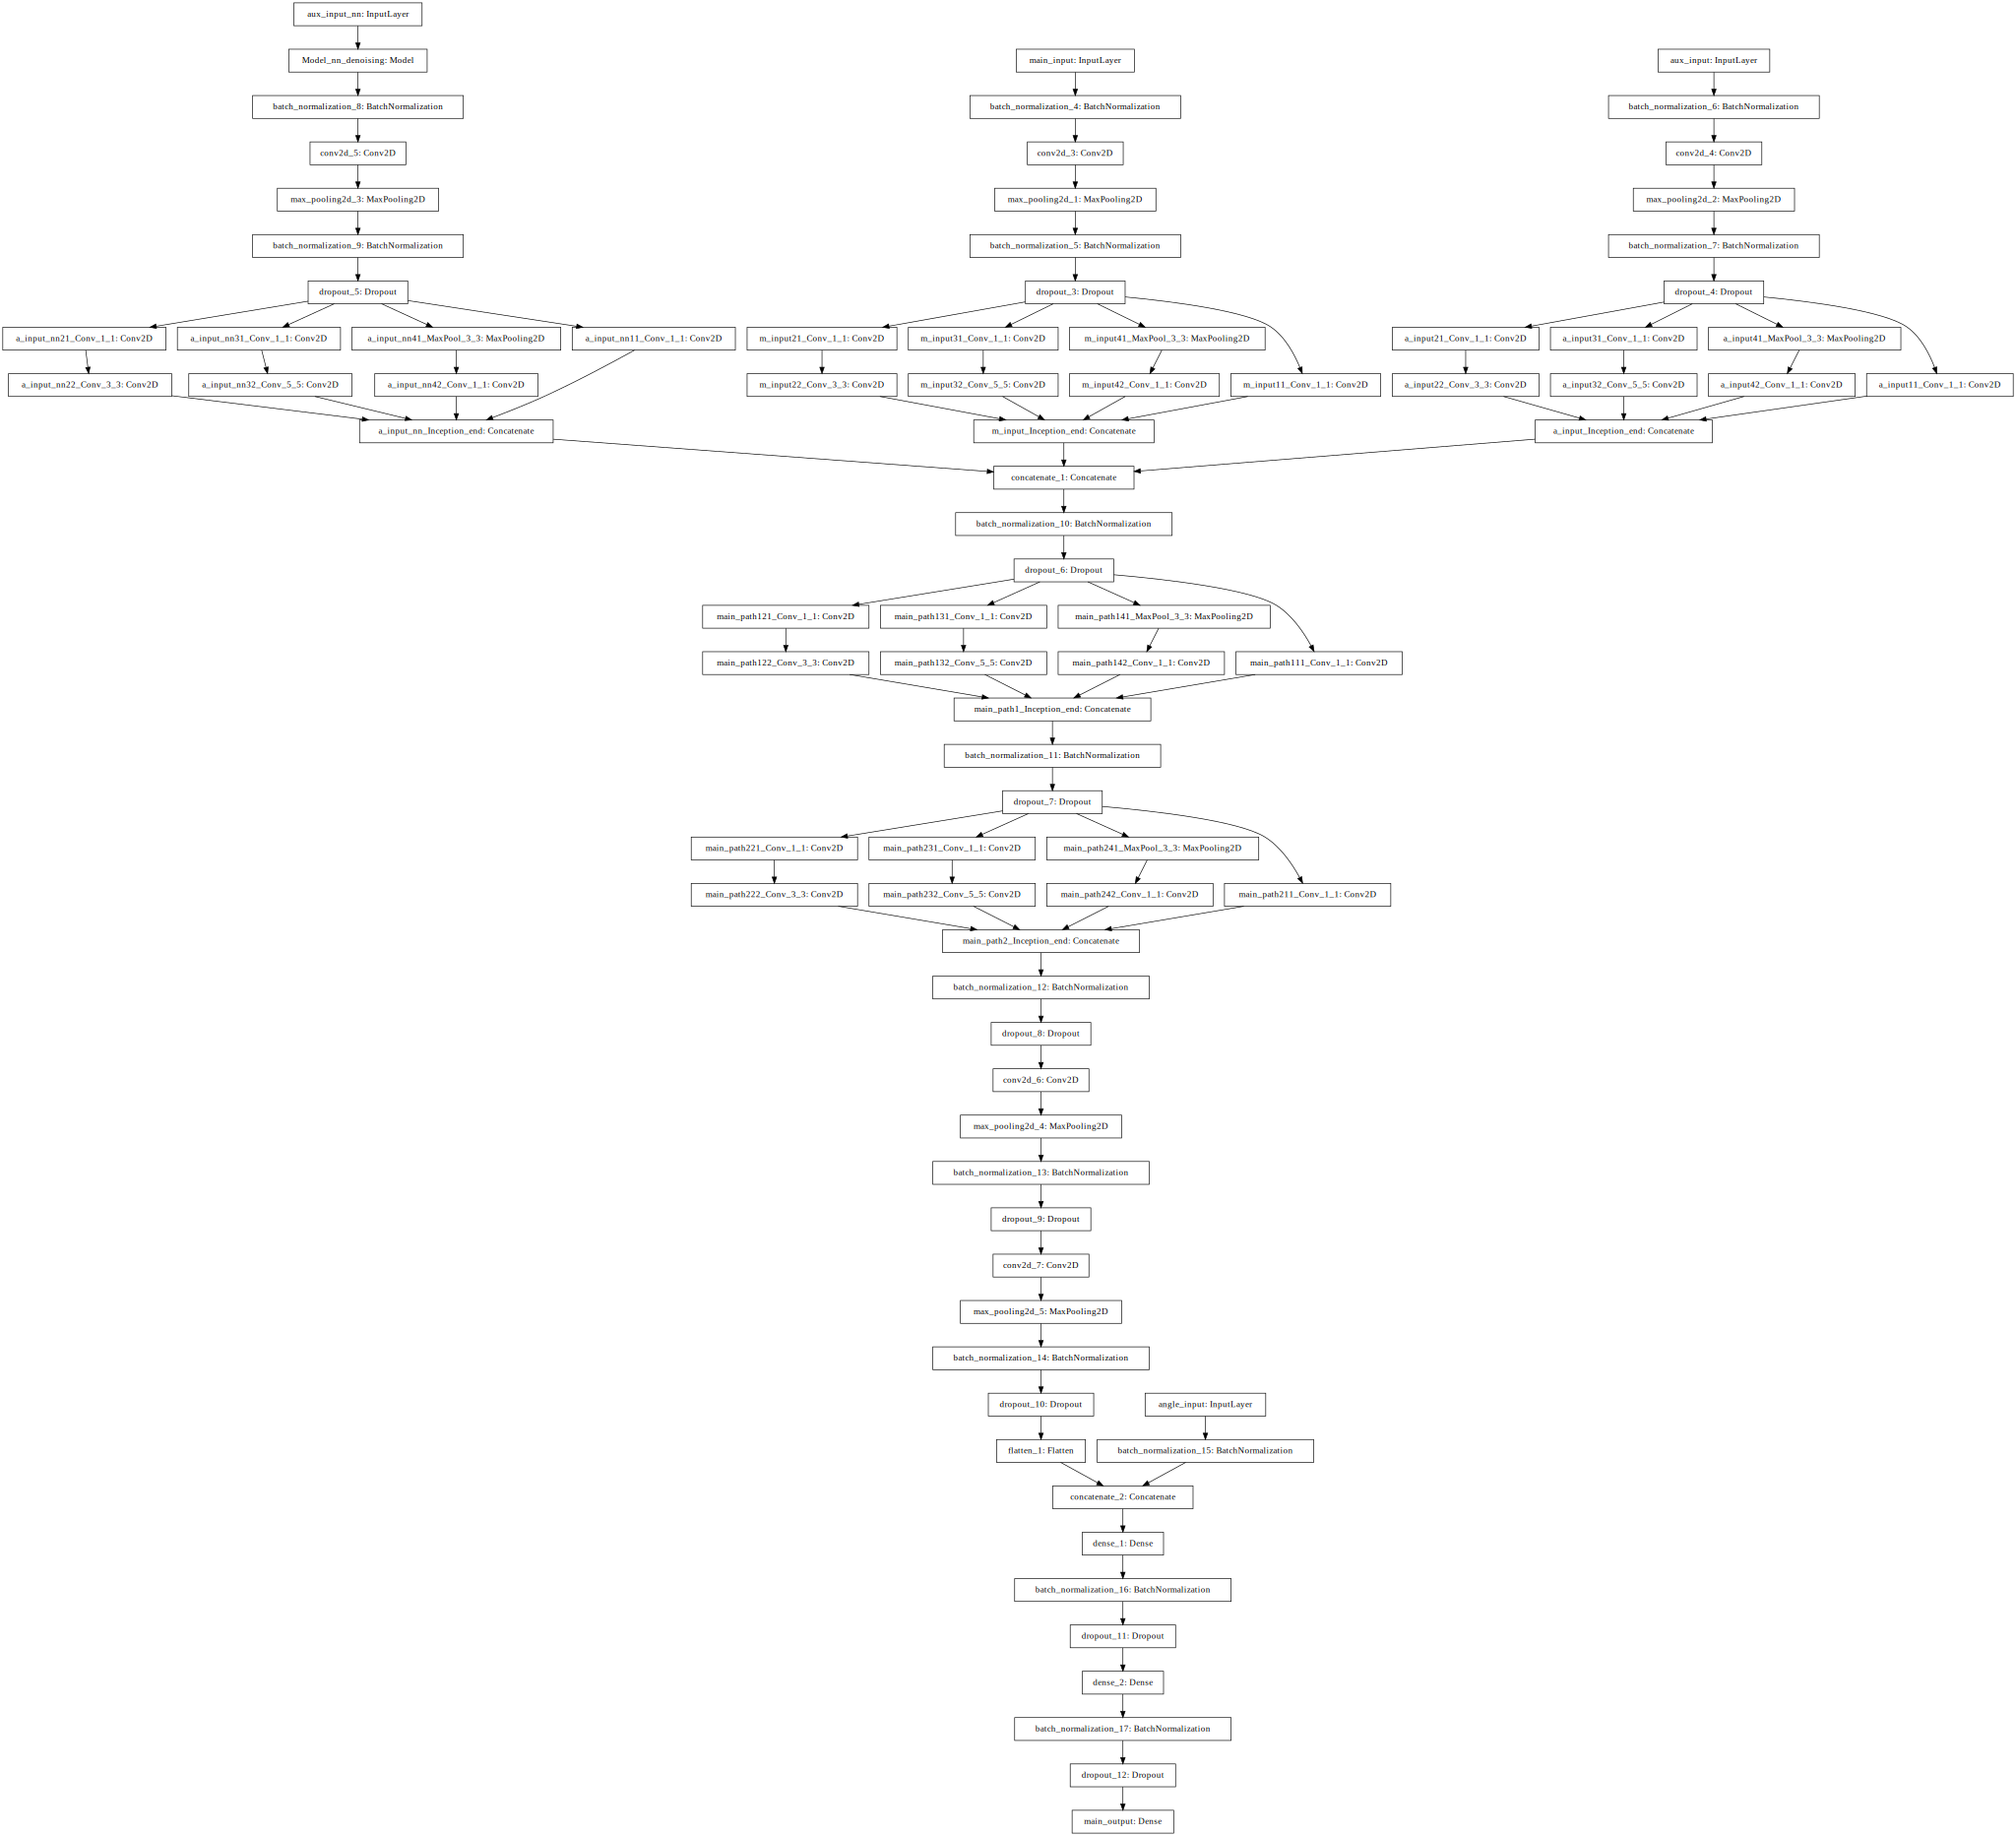

In [39]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

### Model Training

In [64]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay)

In [65]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=batch_size),
                    steps_per_epoch=len(X_train_sample)/batch_size,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=batch_size, shuffle=False), 
                    validation_steps=len(X_val)/(batch_size/2),
                    #validation_data=[X_val,y_val],
                    epochs=56, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/56
18/17 [==============================] - 9s 520ms/step - loss: 0.7764 - acc: 0.6346 - val_loss: 0.6970 - val_acc: 0.5747
Epoch 2/56
18/17 [==============================] - 3s 159ms/step - loss: 0.6176 - acc: 0.7002 - val_loss: 0.6656 - val_acc: 0.6224
Epoch 3/56
18/17 [==============================] - 2s 132ms/step - loss: 0.4820 - acc: 0.7693 - val_loss: 1.0916 - val_acc: 0.5436
Epoch 4/56
18/17 [==============================] - 2s 131ms/step - loss: 0.4252 - acc: 0.8117 - val_loss: 1.4303 - val_acc: 0.5270
Epoch 5/56
18/17 [==============================] - 2s 131ms/step - loss: 0.4344 - acc: 0.8193 - val_loss: 1.8158 - val_acc: 0.4855
Epoch 6/56
18/17 [==============================] - 2s 131ms/step - loss: 0.4076 - acc: 0.8070 - val_loss: 1.8549 - val_acc: 0.4876
Epoch 7/56
18/17 [==============================] - 2s 131ms/step - loss: 0.3596 - acc: 0.8360 - val_loss: 2.1987 - val_acc: 0.4876
Setting learning rate:  0.00066
Epoch 8/56
18/

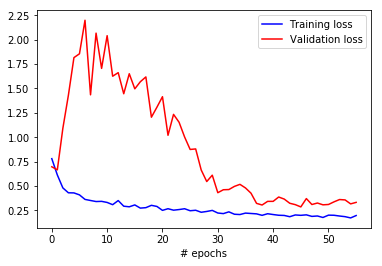

In [66]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [68]:
#addtional training epochs
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay2)
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=128),
                    steps_per_epoch=len(X_train_sample)/128,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=128, shuffle=False), 
                    validation_steps=len(X_val)/64,
                    #validation_data=[X_val,y_val],
                    epochs=56, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  1e-06
Epoch 1/56
9/8 [==============================] - 3s 319ms/step - loss: 0.1796 - acc: 0.9151 - val_loss: 0.3558 - val_acc: 0.8734
Epoch 2/56
9/8 [==============================] - 3s 300ms/step - loss: 0.1584 - acc: 0.9374 - val_loss: 0.3527 - val_acc: 0.8755
Epoch 3/56
9/8 [==============================] - 3s 298ms/step - loss: 0.1691 - acc: 0.9329 - val_loss: 0.3505 - val_acc: 0.8734
Epoch 4/56
9/8 [==============================] - 3s 295ms/step - loss: 0.1533 - acc: 0.9372 - val_loss: 0.3492 - val_acc: 0.8734
Epoch 5/56
9/8 [==============================] - 3s 297ms/step - loss: 0.1701 - acc: 0.9308 - val_loss: 0.3480 - val_acc: 0.8734
Setting learning rate:  6.6e-07
Epoch 6/56
9/8 [==============================] - 3s 297ms/step - loss: 0.1785 - acc: 0.9232 - val_loss: 0.3460 - val_acc: 0.8734
Epoch 7/56
9/8 [==============================] - 3s 299ms/step - loss: 0.1666 - acc: 0.9287 - val_loss: 0.3453 - val_acc: 0.8734
Epoch 8/56
9/8 [============

In [69]:
for key in H.history:
    H.history[key].extend(H2.history[key])

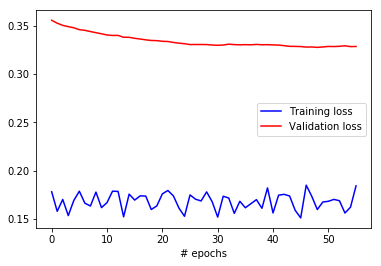

In [70]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

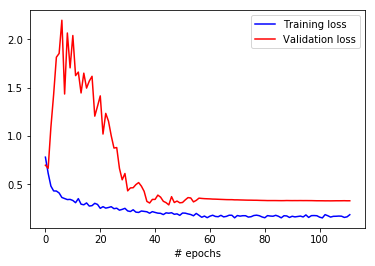

In [71]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [72]:
model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
model_f.save(model_object_path)
#model_f = load_model(model_object_path)

### Saving model history

In [74]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
with open('current_model.py','r') as model_python_code_file:
    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
                                    "val_loss [min]":[H.history['val_loss'][argmin]],
                                    "epoch [val_loss [min]]":argmin,
                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
                                    
                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
                                    "epoch [val_acc [max]]":argmax_acc,
                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
                                    
                                    "model_path":[model_object_path],
                                    "model_weights_path":[model_best_weights_path],
                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
                                    "model_comment":[model_comment]
                                })
                               
models_history = models_history[["timestamp", 
                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
                                 "model_path","model_weights_path","model_python_code","model_comment"]]
models_history.head()

,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
0,2017_12_20_22_08_54,45,0.285904,0.199626,0.877593,0.918895,47,0.881743,0.188745,0.310434,0.930481,/iceberg\models\model.CNN_2017_12_19_v15_2017_...,/iceberg\models\weights.CNN_2017_12_19_v15_201...,"\ndef InceptionBlock(x, n_kernels=32, prefix='...","VOLTA 2 CNN inputs 3,3 conv filters - inceptio..."


In [75]:
print("model comment:", model_comment)
print("Min validation loss epoch:")
print("epoch: %d" %(argmin),
      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
     )
print("Max validation accuracy epoch:")
print("epoch: %d" %(argmax_acc),
      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
     )


model comment: VOLTA 2 CNN inputs 3,3 conv filters - inception module less inputs
Min validation loss epoch:
epoch: 45 ; val loss [min] 0.2859:  ; training loss: 0.1996 ; val acc: 0.8776 ; training acc: 0.9189 
Max validation accuracy epoch:
epoch: 47 ; val loss 0.3104:  ; training loss: 0.1887 ; val acc [max]: 0.8817 ; training acc: 0.9305 


In [76]:
with open('models_history.csv', 'a') as f:
    models_history.to_csv(f, header=False,index=False)
    #models_history.to_csv(f, index=False)

In [51]:
df = pd.read_csv('models_history.csv')
df.tail()

,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
11,2017_12_20_07_28_19,48,0.238980,0.142688,0.903192,0.951872,61,0.904255,0.108134,0.256440,0.956328,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\nmain_input = Input(shape=(75,75,2), name='ma...","2 CNN inputs 3,3 conv filters - wavelet denoising"
12,2017_12_20_12_32_07,43,0.208248,0.184343,0.919872,0.926916,43,0.919872,0.184343,0.208248,0.926916,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,\ndef InputBlock(x):\n #conv layers for inp...,"2 CNN inputs 3,3 conv filters - wavelet denoising"
13,2017_12_20_15_58_15,42,0.230976,0.288447,0.896660,0.878788,25,0.902923,0.356303,0.246267,0.838681,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,\ndef InputBlock(x):\n #conv layers for inp...,"2 CNN inputs 3,3 conv filters - added denoisin..."
14,2017_12_20_18_59_45,53,0.229415,0.235031,0.900641,0.905526,49,0.905983,0.234743,0.231398,0.910873,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,\ndef InputBlock(x):\n #conv layers for inp...,"2 CNN inputs 3,3 conv filters - added dilated ..."
15,2017_12_20_22_00_59,69,0.614301,0.279042,0.788871,0.887701,65,0.795417,0.245432,0.628517,0.890374,/iceberg\models\model.CNN_2017_12_19_v15_2017_...,/iceberg\models\weights.CNN_2017_12_19_v15_201...,"\ndef InceptionBlock(x, n_kernels=32, prefix='...","2 CNN inputs 3,3 conv filters - inception modu..."


### Predictions

In [52]:
model_f.load_weights(model_best_weights_path)

In [53]:
model_f.evaluate(X_val,y_val, verbose=1, batch_size=64)

ValueError: The model expects 4 input arrays, but only received one array. Found: array with shape (482, 75, 75, 4)

In [ ]:
test_df = pd.read_json("Data/test/test.json")

In [ ]:
test_df.head()

In [ ]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)

In [ ]:
predictions = model.predict(X_test,verbose=1, batch_size=64)

In [ ]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions.reshape(-1)})
submission.head()

In [ ]:
submission.to_csv("submission.v7.csv", index=False)